<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

### Problem statement: 
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

### Data Overview
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting  
data contains two columns source and destination eac edge in graph 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  

### Mapping the problem into supervised learning problem:
- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 
- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

### Business objectives and constraints:  
- No low-latency requirement.
- Probability of prediction is useful to recommend ighest probability links

### Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- Confusion matrix

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd  #pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
#if numpy is not installed already : pip3 install numpy
import numpy as np  # Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns    #Plots
from matplotlib import rcParams      #Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans    #Clustering
import math
import pickle
import tqdm
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
## Reading the graph
if not os.path.isfile('train_woheader.csv'):
    traincsv =  pd.read_csv('train.csv')
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    print('Number of duplicates entry',sum(traincsv.duplicated()))
    traincsv.to_csv('train_woheader.csv',header=False,index=False)
    print('Saved the graph into file')
    g=nx.read_edgelist('train_woheader.csv',delimiter=',',
                       create_using=nx.DiGraph(),nodetype=int)
else:
    g=nx.read_edgelist('train_woheader.csv',delimiter=',',
                       create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(g))


Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


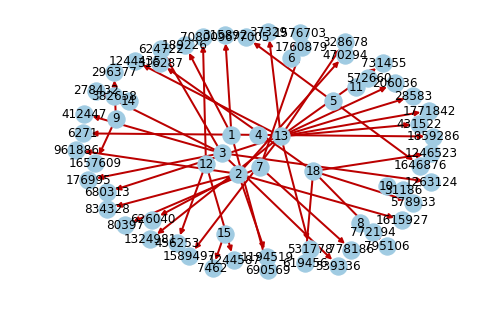

In [3]:
## lets create a subgraph and visualize it 
if not os.path.isfile('train_woheader_sample.csv'):
    pd.read_csv('train.csv',nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False) 

subgraph = nx.read_edgelist('train_woheader_sample.csv',delimiter=',',
                       create_using=nx.DiGraph(),nodetype=int)
pos = nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#BB0000',width=2,
        edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig('graph_sample.pdf')
print(nx.info(subgraph))

# 1. Exploratory Data Analysis


In [4]:
## Number of unique persons
print('The Number of unique persons in the node ',len(g.nodes()))

The Number of unique persons in the node  1862220


### 1.1 Number of Followers for each person 

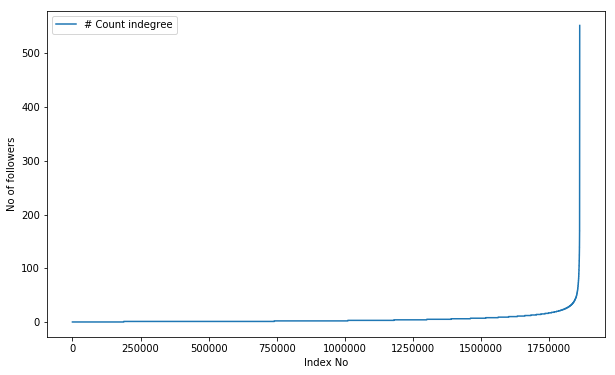

In [5]:
## Number of followers of each person 
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist,label='# Count indegree')
plt.xlabel('Index No')
plt.ylabel('No of followers')
plt.legend()
plt.show()

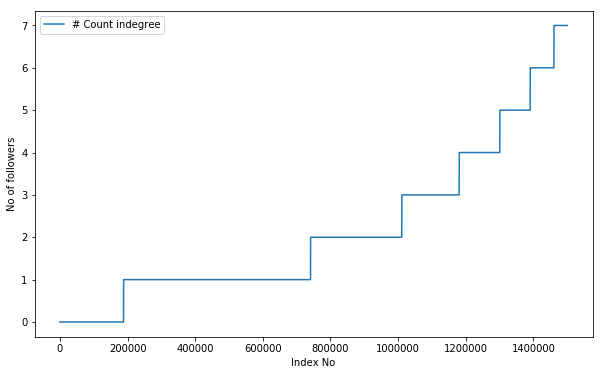

In [6]:
## Lets zoom the portion where there is lot of followers
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000],label='# Count indegree')
plt.xlabel('Index No')
plt.ylabel('No of followers')
plt.legend()
plt.show()

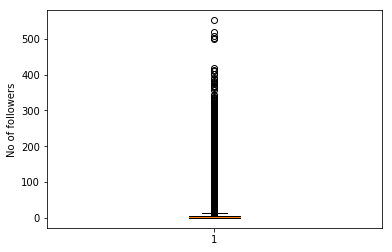

In [7]:
plt.boxplot(indegree_dist)
plt.ylabel('No of followers')
plt.show()

In [8]:
### 90th to 100th percentile 
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))
print('*'*50)    
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0
**************************************************
99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


In [9]:
print('99% of people having 40 or less followers')

99% of people having 40 or less followers


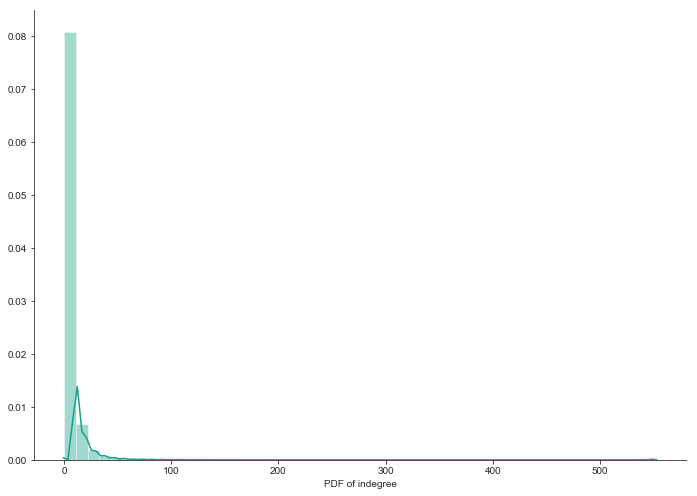

In [10]:
%matplotlib inline
sns.set_style('ticks')
fig,ax = plt.subplots()
fig.set_size_inches(11.7,8.27)
sns.distplot(indegree_dist,color='#16A085')
plt.xlabel('PDF of indegree')
sns.despine()

### 1.2 Number of Followees for each person 


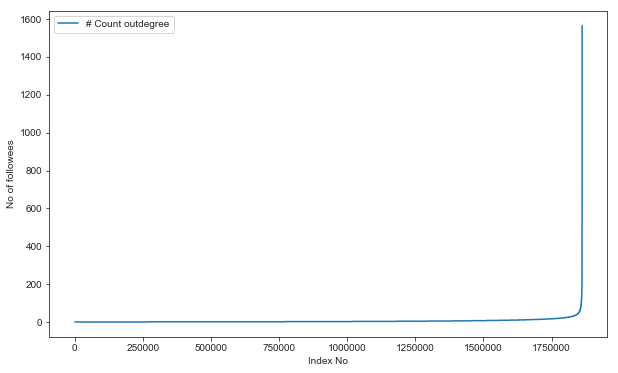

In [11]:
## Number of followers of each person 
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist,label='# Count outdegree')
plt.xlabel('Index No')
plt.ylabel('No of followees')
plt.legend()
plt.show()

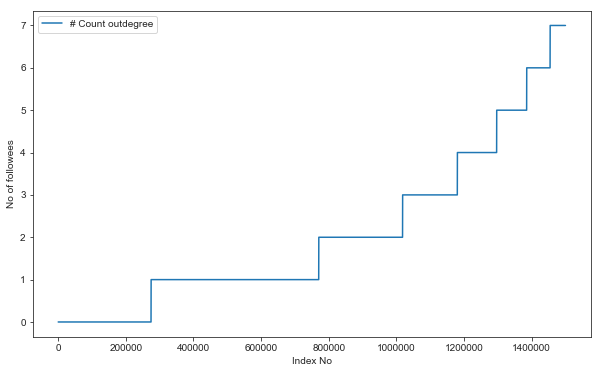

In [12]:
## Lets zoom the portion where there is lot of followers
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000],label='# Count outdegree')
plt.xlabel('Index No')
plt.ylabel('No of followees')
plt.legend()
plt.show()

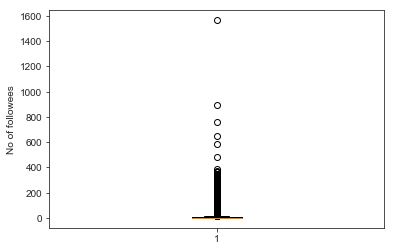

In [13]:
plt.boxplot(outdegree_dist)
plt.ylabel('No of followees')
plt.show()

In [14]:
### 90th to 100th percentile 
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))  
print('*'*50)    
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))    

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0
**************************************************
99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


In [15]:
print('99% of people having 40 or less followees')

99% of people having 40 or less followees


No handles with labels found to put in legend.


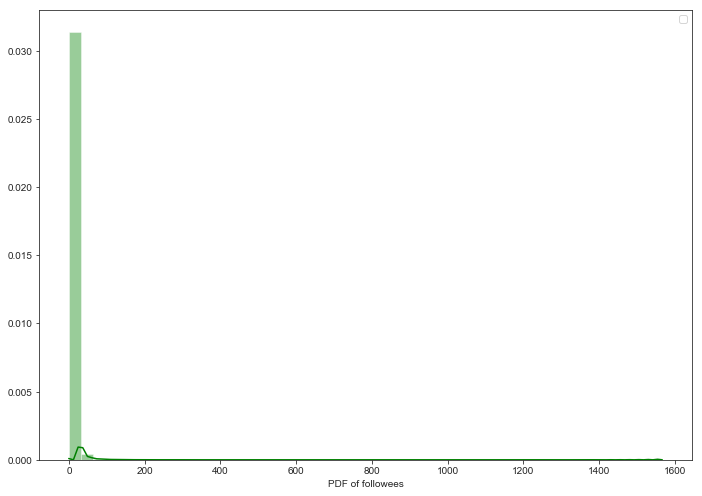

In [16]:
sns.set_style('ticks')
fig,ax = plt.subplots()
fig.set_size_inches(11.7,8.27)
sns.distplot(outdegree_dist,color='green')
plt.xlabel('PDF of followees')
plt.legend()

In [17]:
### Number of people who are not following anyone are 
print('Number of people who are not following anyone are ',sum(np.array(outdegree_dist)==0),
     'and % is',sum(np.array(outdegree_dist)==0)*100 /len(outdegree_dist))
### Number of people who are not having any followers
print('Number of people who are not having any followers ',sum(np.array(indegree_dist)==0),
     'and % is',sum(np.array(indegree_dist)==0)*100 /len(indegree_dist))
### Number of people who are having zero followers +  zero followees
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 and len(list(g.successors(i)))==0:
        count+=1
print('Number of people who are having zero followers +  zero followees are',count)

Number of people who are not following anyone are  274512 and % is 14.7411154429
Number of people who are not having any followers  188043 and % is 10.0977865129
Number of people who are having zero followers +  zero followees are 0


### 1.3 Both followers + following 


In [18]:
from collections import Counter
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree_dict = np.array(list(d.values()))

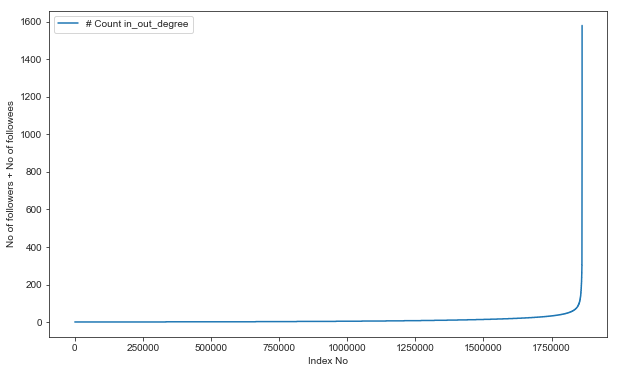

In [19]:
## Number of followers of each person 
in_out_degree_dict.sort()
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_dict,label='# Count in_out_degree')
plt.xlabel('Index No')
plt.ylabel('No of followers + No of followees')
plt.legend()
plt.show()

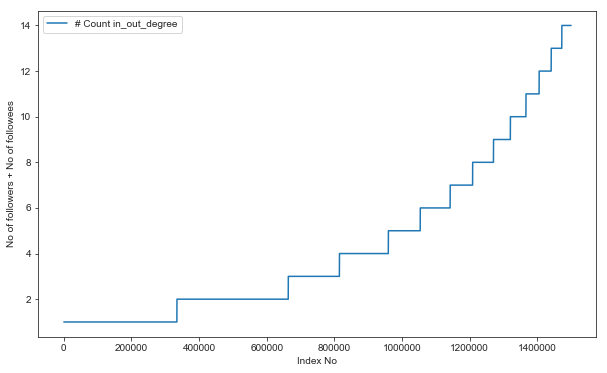

In [20]:
## Lets zoom the portion where there is lot of followers
in_out_degree_dict.sort()
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_dict[0:1500000],label='# Count in_out_degree')
plt.xlabel('Index No')
plt.ylabel('No of followers + No of followees')
plt.legend()
plt.show()

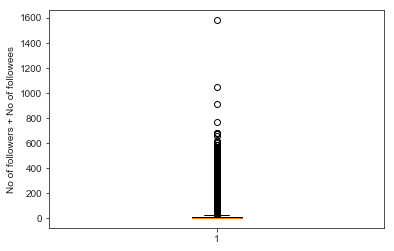

In [21]:
plt.boxplot(in_out_degree_dict)
plt.ylabel('No of followers + No of followees')
plt.show()

In [22]:
### 90th to 100th percentile 
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_dict,90+i)) 
print('*'*50)    
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_dict,99+(i/100)))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0
**************************************************
99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [23]:
print('99% of people having 40 or less followees and followers combined')

99% of people having 40 or less followees and followers combined


No handles with labels found to put in legend.


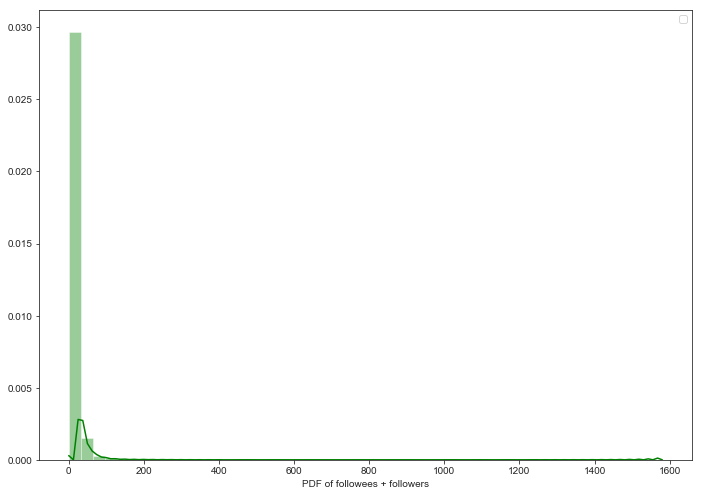

In [24]:
sns.set_style('ticks')
fig,ax = plt.subplots()
fig.set_size_inches(11.7,8.27)
sns.distplot(in_out_degree_dict,color='green')
plt.xlabel('PDF of followees + followers')
plt.legend()

In [25]:
print('Min of no of followers + following is',in_out_degree_dict.min())
print(np.sum(in_out_degree_dict==in_out_degree_dict.min()),' persons having minimum no of followers + following')
print('*'*50)
print('Max of no of followers + following is',in_out_degree_dict.max())
print(np.sum(in_out_degree_dict==in_out_degree_dict.max()),' persons having maximum no of followers + following')
print('*'*50)
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree_dict<10))

Min of no of followers + following is 1
334291  persons having minimum no of followers + following
**************************************************
Max of no of followers + following is 1579
1  persons having maximum no of followers + following
**************************************************
No of persons having followers + following less than 10 are 1320326


In [26]:
print('No of Weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components with 2 nodes',count)

No of Weakly connected components 45558
weakly connected components with 2 nodes 32195


## 2. Posing a problem as classification problem¶


### 2.1 Generating some edges which are not present in graph for supervised learning
* Generated Bad links from graph which are not in graph and whose shortest path is greater than 2

In [27]:
import random
import csv
if not os.path.isfile('missing_edges_final.p'):
    r = csv.reader(open('train_woheader.csv','r'))
    edges = dict()
    for edge in r :
        edges[(edge[0],edge[1])] = 1
    missing_edges = set([])     
    while (len(missing_edges)<9437519):
        a = random.randint(1,1862220)
        b = random.randint(1,1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2:
                    missing_edges.add(a,b)
                else:
                    continue
            except:
                missing_edges.add((a,b))
    pickle.dump(missing_edges,open('missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open('missing_edges_final.p','rb'))

In [28]:
missing_edges = pickle.load(open('missing_edges_final.p','rb'))
len(missing_edges)

9437519

### 2.2 Training and Test data split:
 * Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In [29]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile('train_pos_after_eda.csv')) and (not os.path.isfile('test_pos_after_eda.csv')): 
    #reading total data df
    df_pos = pd.read_csv('train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    print('Number of nodes in graph with edges',df_pos.shape[0])
    print('Number of nodes in graph without edges',df_neg.shape[0])
    ## train test split is done separately for pos and neg because we need pos edges for
    ## feature generation and  creating graph
    x_train_pos,x_test_pos,y_train_pos,y_test_pos = train_test_split(df_pos,np.ones(len(df_pos)))
    x_train_neg,x_test_neg,y_train_neg,y_test_neg = train_test_split(df_neg,np.zeros(len(df_neg)))
    print('='*60)
    print("Number of nodes in the train data graph with edges", x_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", x_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", x_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", x_test_neg.shape[0],"=",y_test_neg.shape[0])
    #removing header and saving
    x_train_pos.to_csv('train_pos_after_eda.csv',header=False, index=False)
    x_test_pos.to_csv('test_pos_after_eda.csv',header=False, index=False)
    x_train_neg.to_csv('train_neg_after_eda.csv',header=False, index=False)
    x_test_neg.to_csv('test_neg_after_eda.csv',header=False, index=False)
    pd.DataFrame(data=y_train_pos,columns=['indicator_link']).to_csv('y_tr_pos_after_eda.csv',header=False, index=False)
    pd.DataFrame(data=y_test_pos,columns=['indicator_link']).to_csv('y_te_pos_after_eda.csv',header=False, index=False)
    pd.DataFrame(data=y_train_neg,columns=['indicator_link']).to_csv('y_tr_neg_after_eda.csv',header=False, index=False)
    pd.DataFrame(data=y_test_neg,columns=['indicator_link']).to_csv('y_te_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Training data only 
    print('deleting ........')
    del missing_edges

deleting ........


In [30]:
if (os.path.isfile('train_pos_after_eda.csv')) and (os.path.isfile('test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist('test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

Name: 
Type: DiGraph
Number of nodes: 1755007
Number of edges: 7078139
Average in degree:   4.0331
Average out degree:   4.0331
Name: 
Type: DiGraph
Number of nodes: 1252565
Number of edges: 2359380
Average in degree:   1.8836
Average out degree:   1.8836
no of people common in train and test --  1145352
no of people present in train but not present in test --  609655
no of people present in test but not present in train --  107213
 % of people not there in Train but exist in Test in total Test data are 8.559475955339643 %


In [34]:
#final train and test data sets
if (os.path.isfile('train_pos_after_eda.csv')) and \
    (os.path.isfile('test_pos_after_eda.csv')) and \
    (os.path.isfile('train_neg_after_eda.csv')) and \
    (os.path.isfile('test_neg_after_eda.csv')) and \
    (os.path.isfile('y_tr_pos_after_eda.csv')) and \
    (os.path.isfile('y_te_pos_after_eda.csv')) and \
    (os.path.isfile('y_tr_neg_after_eda.csv')) and \
    (os.path.isfile('y_te_neg_after_eda.csv')) :
    
    x_train_pos = pd.read_csv('train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    x_test_pos = pd.read_csv('test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    x_train_neg = pd.read_csv('train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    x_test_neg = pd.read_csv('test_neg_after_eda.csv', names=['source_node', 'destination_node']) 
    y_tr_pos = pd.read_csv('y_tr_pos_after_eda.csv', names=['source_node', 'destination_node'])
    y_tr_neg = pd.read_csv('y_tr_neg_after_eda.csv', names=['source_node', 'destination_node'])
    y_te_pos = pd.read_csv('y_te_pos_after_eda.csv', names=['source_node', 'destination_node'])
    y_te_neg = pd.read_csv('y_te_neg_after_eda.csv', names=['source_node', 'destination_node'])    
    print('='*60)
    print("Number of nodes in the train data graph with edges", x_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", x_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", x_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", x_test_neg.shape[0])

    x_train = x_train_pos.append(x_train_neg,ignore_index=True)
    y_train = y_tr_pos.append(y_tr_neg,ignore_index=True)
    x_test = x_test_pos.append(x_test_neg,ignore_index=True)
    y_test = y_te_pos.append(y_te_neg,ignore_index=True) 

    x_train.to_csv('train_after_eda.csv',header=False,index=False)
    x_test.to_csv('test_after_eda.csv',header=False,index=False)
    y_train.to_csv('train_y.csv',header=False,index=False)
    y_test.to_csv('test_y.csv',header=False,index=False)


Number of nodes in the train data graph with edges 7078139
Number of nodes in the train data graph without edges 7078139
Number of nodes in the test data graph with edges 2359380
Number of nodes in the test data graph without edges 2359380


In [35]:
print("Data points in train data",x_train.shape)
print("Data points in test data",x_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

Data points in train data (14156278, 2)
Data points in test data (4718760, 2)
Shape of traget variable in train (14156278, 2)
Shape of traget variable in test (4718760, 2)


## FB featurization

### 1. Reading Data

In [36]:
train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))

Name: 
Type: DiGraph
Number of nodes: 1755007
Number of edges: 7078139
Average in degree:   4.0331
Average out degree:   4.0331


# 2. Similarity measures

## 2.1 Jaccard Distance:
http://www.statisticshowto.com/jaccard-index/

In [37]:
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [38]:
#one test case
print(jaccard_for_followees(273084,1505602))

0.0


In [39]:
#node 1635354 not in graph 
print(jaccard_for_followees(273084,1505602))

0.0


In [40]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [41]:
print(jaccard_for_followers(273084,470294))

0.0


In [42]:
#node 1635354 not in graph 
print(jaccard_for_followees(669354,1635354))

0


## 2.2 Cosine distance

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{sqrt{|X|\cdot|Y|}} 
\end{equation}

In [43]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [44]:
print(cosine_for_followees(273084,1505602))

0.0


In [45]:
print(cosine_for_followees(273084,1635354))

0


In [46]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [47]:
print(cosine_for_followers(2,470294))

0.0


In [48]:
print(cosine_for_followers(669354,1635354))

0


## 3. Ranking Measures

https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.

<img src='PageRanks-Example.jpg'/>

Mathematical PageRanks for a simple network, expressed as percentages. (Google uses a logarithmic scale.) Page C has a higher PageRank than Page E, even though there are fewer links to C; the one link to C comes from an important page and hence is of high value. If web surfers who start on a random page have an 85% likelihood of choosing a random link from the page they are currently visiting, and a 15% likelihood of jumping to a page chosen at random from the entire web, they will reach Page E 8.1% of the time. <b>(The 15% likelihood of jumping to an arbitrary page corresponds to a damping factor of 85%.) Without damping, all web surfers would eventually end up on Pages A, B, or C, and all other pages would have PageRank zero. In the presence of damping, Page A effectively links to all pages in the web, even though it has no outgoing links of its own.</b>

## 3.1 Page Ranking

https://en.wikipedia.org/wiki/PageRank


In [49]:
if not os.path.isfile('page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(pr,open('page_rank.p','wb'))
else:
    pr = pickle.load(open('page_rank.p','rb'))

In [50]:
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))

min 1.710937236609678e-07
max 2.713872959435951e-05
mean 5.697982970986667e-07


In [51]:
#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

5.697982970986667e-07


# 4. Other Graph Features

## 4.1 Shortest path:
Getting Shortest path between twoo nodes, if nodes have direct path i.e directly connected then we are removing that edge and calculating path. 

In [52]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p = nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
            return p
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            return p
    except:
        return -1

In [53]:
#testing
compute_shortest_path_length(1550756,583691)

3

In [54]:
#testing
compute_shortest_path_length(669354,1635354)

-1

## 4.2 Checking for same community


In [55]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [56]:
belongs_to_same_wcc(861, 1659750)

0

In [57]:
belongs_to_same_wcc(669354,1635354)

0

## 4.3 Adamic/Adar Index:
Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [58]:
#adar index
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [59]:
calc_adar_in(1,189226)

0

In [60]:
calc_adar_in(669354,1635354)

0

## 4.4 If person was following back:

In [61]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [62]:
follows_back(1,189226)

1

In [63]:
follows_back(669354,1635354)

0

## 4.5 Katz Centrality:
https://en.wikipedia.org/wiki/Katz_centrality

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/
 Katz centrality computes the centrality for a node 
    based on the centrality of its neighbors. It is a 
    generalization of the eigenvector centrality. The
    Katz centrality for node `i` is
 
$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$
where `A` is the adjacency matrix of the graph G 
with eigenvalues $$\lambda$$.

The parameter $$\beta$$ controls the initial centrality and 

$$\alpha < \frac{1}{\lambda_{max}}.$$

In [64]:
if not os.path.isfile('katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open('katz.p','wb'))
else:
    katz = pickle.load(open('katz.p','rb'))

In [65]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.0007377861743833067
max 0.0030406227082377937
mean 0.0007540061180221656


In [66]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007540061180221656


## 4.6 Hits Score
The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

https://en.wikipedia.org/wiki/HITS_algorithm

In [67]:
if not os.path.isfile('hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open('hits.p','wb'))
else:
    hits = pickle.load(open('hits.p','rb'))

In [68]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min 0.0
max 0.00520119619968776
mean 5.697982971018867e-07


# 5. Featurization

## 5. 1 Reading a sample of Data from both train and test

In [69]:
import random 
if os.path.isfile('train_after_eda.csv'):
    filename = "train_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 15100030
    n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    #https://stackoverflow.com/a/22259008/4084039

In [70]:
if os.path.isfile('train_after_eda.csv'):
    filename = "test_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    #https://stackoverflow.com/a/22259008/4084039

In [71]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 14156278
Number of rows we are going to elimiate in train data are 14056278
Number of rows in the test data file: 4718760
Number of rows we are going to elimiate in test data are 4668760


In [72]:
df_final_train = pd.read_csv('train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('train_y.csv', skiprows=skip_train, names=['indicator_link'],index_col=False)
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (100001, 3)


,source_node,destination_node,indicator_link
0,1055841,514429,1.0
1,898694,385431,1.0


In [73]:
df_final_test = pd.read_csv('test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('test_y.csv', skiprows=skip_test, names=['indicator_link'],index_col=False)
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (50001, 3)


,source_node,destination_node,indicator_link
0,1099069,36203,1.0
1,589270,72825,1.0


In [74]:

#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

## 5.2 Adding a set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>jaccard_followers</li>
<li>jaccard_followees</li>
<li>cosine_followers</li>
<li>cosine_followees</li>
<li>num_followers_s</li>
<li>num_followees_s</li>
<li>num_followers_d</li>
<li>num_followees_d</li>
<li>inter_followers</li>
<li>inter_followees</li>
</ol>

In [75]:
if not os.path.isfile('storage_sample_stage1.h5'):
    #mapping jaccrd followers to train and test data
    df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    

        #mapping jaccrd followers to train and test data
    df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

In [76]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [77]:
if not os.path.isfile('storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = pd.HDFStore('storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = pd.read_hdf('storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = pd.read_hdf('storage_sample_stage1.h5', 'test_df',mode='r')

## 5.3 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>adar index</li>
<li>is following back</li>
<li>belongs to same weakly connect components</li>
<li>shortest path between source and destination</li>
</ol>

In [78]:
if not os.path.isfile('storage_sample_stage2.h5'):
    #mapping adar index on train
    df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
    df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping followback or not on train
    df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping followback or not on test
    df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    ##mapping same component of wcc or not on train
    df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    #mapping shortest path on train 
    df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    #mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

    hdf = pd.HDFStore('storage_sample_stage2.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = pd.read_hdf('storage_sample_stage2.h5', 'train_df',mode='r')
    df_final_test = pd.read_hdf('storage_sample_stage2.h5', 'test_df',mode='r')

## 5.4 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of source</li>
<li>Page Ranking of dest</li>
<li>katz of source</li>
<li>katz of dest</li>
<li>hubs of source</li>
<li>hubs of dest</li>
<li>authorities_s of source</li>
<li>authorities_s of dest</li>
</ol>

#### Weight Features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 
`credit` - Graph-based Features for Supervised Link Prediction
William Cukierski, Benjamin Hamner, Bo Yang

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}

it is directed graph so calculated Weighted in and Weighted out differently

In [79]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in train_graph.nodes():
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

In [80]:
if not os.path.isfile('data/fea_sample/storage_sample_stage3.h5'):
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [81]:
if not os.path.isfile('storage_sample_stage3.h5'):
    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

    hdf = pd.HDFStore('storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = pd.read_hdf('storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = pd.read_hdf('storage_sample_stage3.h5', 'test_df',mode='r')

In [82]:
if not os.path.isfile('storage_sample_stage3.h5'):
    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

    hdf = pd.HDFStore('storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = pd.read_hdf('storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = pd.read_hdf('storage_sample_stage3.h5', 'test_df',mode='r')

## 5.5 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>SVD features for both source and destination</li>
</ol>

In [83]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [84]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [85]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [86]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1755007, 1755007)
U Shape (1755007, 6)
V Shape (6, 1755007)
s Shape (6,)


In [94]:
if not os.path.isfile('storage_sample_stage4.h5'):
    #===================================================================================================
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

    hdf = HDFStore('storage_sample_stage4.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = pd.read_hdf('storage_sample_stage4.h5', 'train_df',mode='r')
    df_final_test = pd.read_hdf('storage_sample_stage4.h5', 'test_df',mode='r')

In [95]:
df_final_test.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,1099069,36203,1.0,0.000000,0.000000,0.000000,0.000000,6,0,8,...,-1.502736e-07,1.956240e-14,4.281981e-13,8.794428e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,198329,1522280,1.0,0.571429,0.333333,0.163299,0.503953,24,20,18,...,-1.023363e-14,5.172288e-14,2.810538e-16,4.385595e-17,3.469511e-16,-1.294069e-15,-1.017365e-14,5.149842e-14,2.720997e-16,4.374572e-17


### 5.6 Adding new Feature:  Preferential attachment 
     * One well-known concept in social networks is that users with many friends tend to create more connections in the future. This is due to the fact that in some social networks, like in finance, the rich get richer. We estimate how ”rich” our two vertices are by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has. It may be noted that the similarity index does not require any node neighbor information; therefore, this similarity index has the lowest computational complexity.

#### Preferential attachment for followers

In [96]:
## number of followers of source * number of followers of destination train 
num_f_dest_tr = np.array(df_final_train['num_followers_d'])
num_f_source_tr = np.array(df_final_train['num_followers_s'])
pref_followers = []
for i in range(len(num_f_source_tr)):
    pref_followers.append(num_f_source_tr[i]*num_f_dest_tr[i])
df_final_train['preferential_attach_followers'] =  pref_followers
df_final_train.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_attach_followers
0,1055841,514429,1.0,0.489796,0.224299,0.078657,0.383816,76,70,46,...,1.915737e-11,1.541002e-14,2.221265e-06,1.629140e-12,-2.823192e-14,-1.308922e-12,2.077324e-11,1.436135e-14,0.000002,5320
1,1281867,313127,1.0,0.000000,0.000000,0.000000,0.000000,1,1,2,...,3.765042e-15,1.091447e-13,1.725994e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1


In [97]:
## number of followers of source_te * number of followers of dest_teination test 
num_f_dest_te = np.array(df_final_test['num_followers_d'])
num_f_source_te = np.array(df_final_test['num_followers_s'])
pref_followers = []
for i in range(len(num_f_source_te)):
    pref_followers.append(num_f_source_te[i]*num_f_dest_te[i])
df_final_test['preferential_attach_followers'] =  pref_followers
df_final_test.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_attach_followers
0,1099069,36203,1.0,0.000000,0.000000,0.000000,0.000000,6,0,8,...,1.956240e-14,4.281981e-13,8.794428e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0
1,198329,1522280,1.0,0.571429,0.333333,0.163299,0.503953,24,20,18,...,5.172288e-14,2.810538e-16,4.385595e-17,3.469511e-16,-1.294069e-15,-1.017365e-14,5.149842e-14,2.720997e-16,4.374572e-17,480


#### Preferential attachment for followees

In [98]:
## number of followees of source * number of followees of destination train 
num_f_dest_tr = np.array(df_final_train['num_followees_d'])
num_f_source_tr = np.array(df_final_train['num_followees_s'])
pref_followees = []
for i in range(len(num_f_source_tr)):
    pref_followees.append(num_f_source_tr[i]*num_f_dest_tr[i])
df_final_train['preferential_attach_followees'] =  pref_followees
df_final_train.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_attach_followers,preferential_attach_followees
0,1055841,514429,1.0,0.489796,0.224299,0.078657,0.383816,76,70,46,...,1.541002e-14,2.221265e-06,1.629140e-12,-2.823192e-14,-1.308922e-12,2.077324e-11,1.436135e-14,0.000002,5320,3910
1,1281867,313127,1.0,0.000000,0.000000,0.000000,0.000000,1,1,2,...,1.091447e-13,1.725994e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1,0


In [99]:
## number of followees of source_te * number of followees of dest_teination test 
num_f_dest_te = np.array(df_final_test['num_followees_d'])
num_f_source_te = np.array(df_final_test['num_followees_s'])
pref_followees = []
for i in range(len(num_f_source_te)):
    pref_followees.append(num_f_source_te[i]*num_f_dest_te[i])
df_final_test['preferential_attach_followees'] =  pref_followees
df_final_test.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_attach_followers,preferential_attach_followees
0,1099069,36203,1.0,0.000000,0.000000,0.000000,0.000000,6,0,8,...,4.281981e-13,8.794428e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,16
1,198329,1522280,1.0,0.571429,0.333333,0.163299,0.503953,24,20,18,...,2.810538e-16,4.385595e-17,3.469511e-16,-1.294069e-15,-1.017365e-14,5.149842e-14,2.720997e-16,4.374572e-17,480,252


### 5.7 Adding new Feature:  SVD_dot 
     * SVD dot is the dot product between source svd and destination svd
     * Dot product of columns a and b in low-rank approximation

In [100]:
## lets get all the source svd for traindata
s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12 = \
df_final_train['svd_u_s_1'],df_final_train['svd_u_s_2'],df_final_train['svd_u_s_3'],\
df_final_train['svd_u_s_4'],df_final_train['svd_u_s_5'],df_final_train['svd_u_s_6'],\
df_final_train['svd_v_s_1'],df_final_train['svd_v_s_2'],df_final_train['svd_v_s_3'],\
df_final_train['svd_v_s_4'],df_final_train['svd_v_s_5'],df_final_train['svd_v_s_6']

## lets get all the destination svd
d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12 = \
df_final_train['svd_u_d_1'],df_final_train['svd_u_d_2'],df_final_train['svd_u_d_3'],\
df_final_train['svd_u_d_4'],df_final_train['svd_u_d_5'],df_final_train['svd_u_d_6'],\
df_final_train['svd_v_d_1'],df_final_train['svd_v_d_2'],df_final_train['svd_v_d_3'],\
df_final_train['svd_v_d_4'],df_final_train['svd_v_d_5'],df_final_train['svd_v_d_6']

In [101]:
### now we need to get the dot product of all the source and destination svd
svd_dot =[]

for i in tqdm(range(len(s1))):
    ## a has all the source svd and d has all the destination svd
    a,d =[],[]
    a.append(s1[i])
    a.append(s2[i])
    a.append(s3[i])
    a.append(s4[i])
    a.append(s5[i])
    a.append(s6[i])
    a.append(s7[i])
    a.append(s8[i])
    a.append(s9[i])
    a.append(s10[i])
    a.append(s11[i])
    a.append(s12[i])
    d.append(d1[i])
    d.append(d2[i])
    d.append(d3[i])
    d.append(d4[i])
    d.append(d5[i])
    d.append(d6[i])
    d.append(d7[i])
    d.append(d8[i])
    d.append(d9[i])
    d.append(d10[i])
    d.append(d11[i])
    d.append(d12[i])
    svd_dot.append(np.dot(a,d))

100%|████████████████████████████████████████████████████████████████████████| 100001/100001 [00:18<00:00, 5268.75it/s]


In [102]:
## lets get all the source svd for test data
s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12 = \
df_final_test['svd_u_s_1'],df_final_test['svd_u_s_2'],df_final_test['svd_u_s_3'],\
df_final_test['svd_u_s_4'],df_final_test['svd_u_s_5'],df_final_test['svd_u_s_6'],\
df_final_test['svd_v_s_1'],df_final_test['svd_v_s_2'],df_final_test['svd_v_s_3'],\
df_final_test['svd_v_s_4'],df_final_test['svd_v_s_5'],df_final_test['svd_v_s_6']

## lets get all the destination svd
d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12 = \
df_final_test['svd_u_d_1'],df_final_test['svd_u_d_2'],df_final_test['svd_u_d_3'],\
df_final_test['svd_u_d_4'],df_final_test['svd_u_d_5'],df_final_test['svd_u_d_6'],\
df_final_test['svd_v_d_1'],df_final_test['svd_v_d_2'],df_final_test['svd_v_d_3'],\
df_final_test['svd_v_d_4'],df_final_test['svd_v_d_5'],df_final_test['svd_v_d_6']

In [103]:
### now we need to get the dot product of all the source and destination svd
svd_dot_test =[]

for i in tqdm(range(len(s1))):
    ## a has all the source svd and d has all the destination svd
    a,d =[],[]
    a.append(s1[i])
    a.append(s2[i])
    a.append(s3[i])
    a.append(s4[i])
    a.append(s5[i])
    a.append(s6[i])
    a.append(s7[i])
    a.append(s8[i])
    a.append(s9[i])
    a.append(s10[i])
    a.append(s11[i])
    a.append(s12[i])
    d.append(d1[i])
    d.append(d2[i])
    d.append(d3[i])
    d.append(d4[i])
    d.append(d5[i])
    d.append(d6[i])
    d.append(d7[i])
    d.append(d8[i])
    d.append(d9[i])
    d.append(d10[i])
    d.append(d11[i])
    d.append(d12[i])
    svd_dot_test.append(np.dot(a,d))

100%|██████████████████████████████████████████████████████████████████████████| 50001/50001 [00:09<00:00, 5287.42it/s]


In [104]:
### lets append the features in train and test dataset
df_final_train['SVD_dot'] = svd_dot 
df_final_test['SVD_dot'] = svd_dot_test

In [105]:
print('*'*50)
df_final_train.head(2)

**************************************************


,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_attach_followers,preferential_attach_followees,SVD_dot
0,1055841,514429,1.0,0.489796,0.224299,0.078657,0.383816,76,70,46,...,2.221265e-06,1.629140e-12,-2.823192e-14,-1.308922e-12,2.077324e-11,1.436135e-14,0.000002,5320,3910,2.677948e-11
1,1281867,313127,1.0,0.000000,0.000000,0.000000,0.000000,1,1,2,...,1.725994e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1,0,4.315152e-27


In [106]:
print('*'*50)
df_final_test.head(2)

**************************************************


,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_attach_followers,preferential_attach_followees,SVD_dot
0,1099069,36203,1.0,0.000000,0.000000,0.000000,0.000000,6,0,8,...,8.794428e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,16,3.887994e-12
1,198329,1522280,1.0,0.571429,0.333333,0.163299,0.503953,24,20,18,...,4.385595e-17,3.469511e-16,-1.294069e-15,-1.017365e-14,5.149842e-14,2.720997e-16,4.374572e-17,480,252,2.832027e-27


In [107]:
hdf = HDFStore('storage_sample_stage5.h6')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()

### 6. FB_Models

#### 6.1 Applying Random Forest Classifier

In [108]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('storage_sample_stage5.h6', 'train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage5.h6', 'test_df',mode='r')

In [109]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'preferential_attach_followers', 'preferential_attach_followees',
       'SVD_dot'],
      dtype='

In [110]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [111]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.905570995452 test Score 0.897197842868
Estimators =  50 Train Score 0.91157618673 test Score 0.904524305775
Estimators =  100 Train Score 0.912931976793 test Score 0.906034464576
Estimators =  250 Train Score 0.914383165075 test Score 0.907657848026
Estimators =  450 Train Score 0.914664788318 test Score 0.908008612319


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

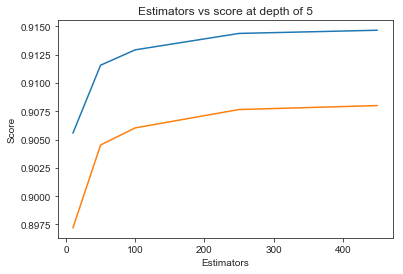

In [112]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.877465845335 test Score 0.847200882907
depth =  9 Train Score 0.954768594276 test Score 0.916144701521
depth =  11 Train Score 0.959819191475 test Score 0.917544604928
depth =  15 Train Score 0.961977806789 test Score 0.918204573416
depth =  20 Train Score 0.962622442843 test Score 0.913369393926
depth =  35 Train Score 0.962707787641 test Score 0.913461947958
depth =  50 Train Score 0.962707787641 test Score 0.913461947958
depth =  70 Train Score 0.962707787641 test Score 0.913461947958
depth =  130 Train Score 0.962707787641 test Score 0.913461947958


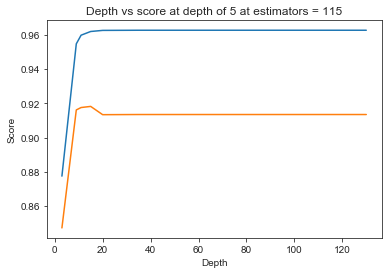

In [113]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [116]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf,return_train_score=True,param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25,verbose=1)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  5.6min finished


mean test scores [ 0.96072737  0.96063258  0.95916736  0.96037088  0.96205632]
mean train scores [ 0.96141384  0.96121795  0.95958134  0.96097284  0.96272726]


In [139]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)


In [137]:
clf = xgb.XGBClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25, scoring='f1',
            oob_score=False, verbose=0, warm_start=False)

In [138]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

[11:50:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_leaf, min_samples_split, oob_score, scoring, verbose, warm_start } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [120]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.962789370721
Test f1 score 0.918308067423


In [121]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


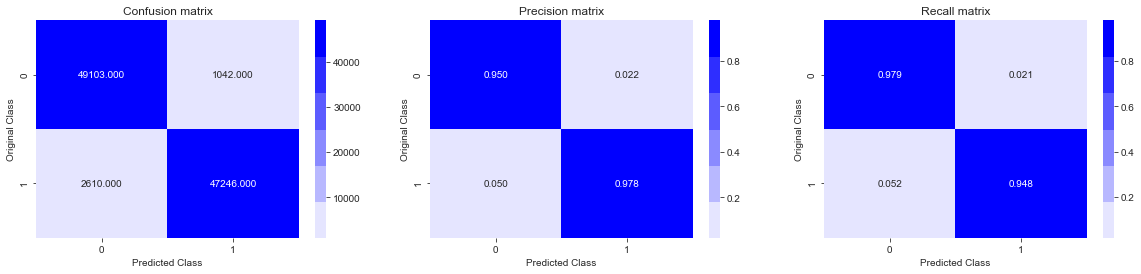

Test confusion_matrix


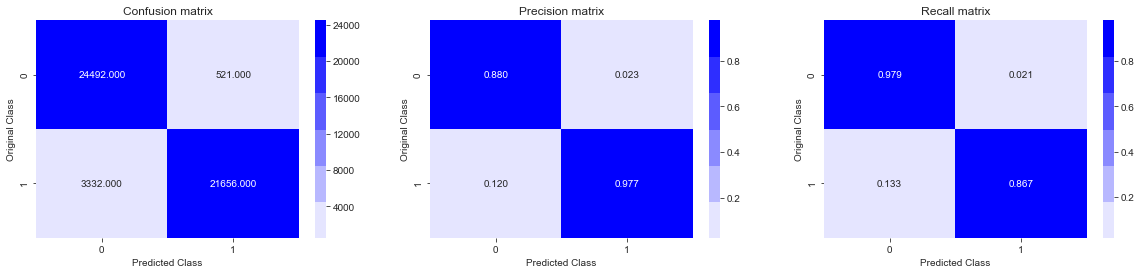

In [122]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

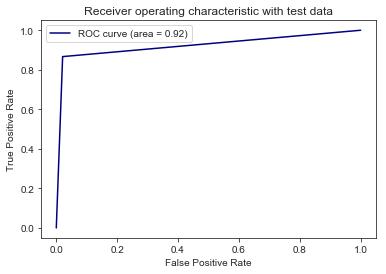

In [123]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

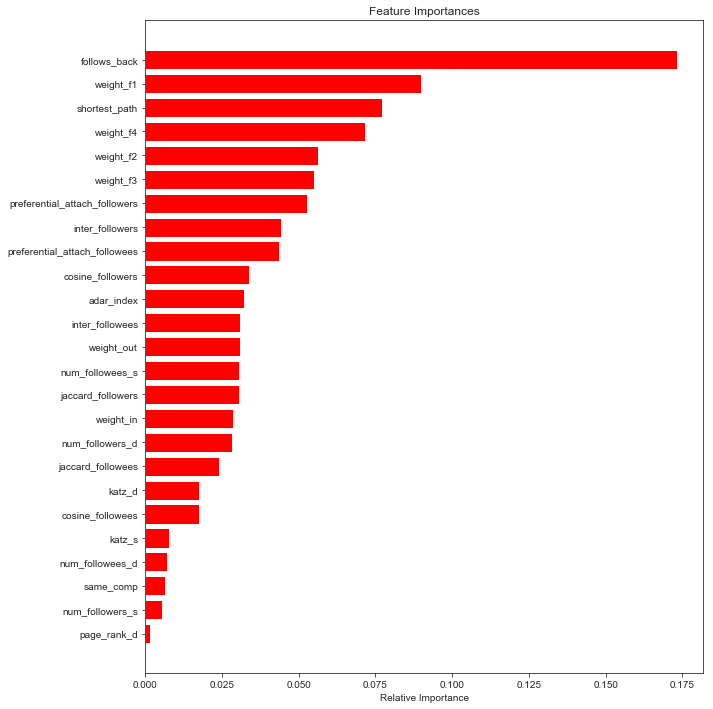

In [124]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### 6.2 Applying XGBoost

In [152]:
## ref : https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
parameters = { 'max_depth':sp_randint(10,15),
             'n_estimators':sp_randint(105,250),
             'min_child_weight':range(1,6,2),
             'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
             'gamma':[0.1,0.2,0.3,0.4,0.5],
             'subsample':[0.5, 0.6, 0.7, 0.8, 0.9],
             'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9] ,
             'reg_alpha':[0.001, 0.005, 0.01, 0.05]
 }
xgb_cl = xgb.XGBClassifier()
rs_xgb = RandomizedSearchCV(xgb_cl, parameters,scoring='f1',n_iter=20,verbose=10,
                            cv=3,refit=False, random_state=42)
rs_xgb.fit(df_final_train,y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=14, min_child_weight=1, n_estimators=207, reg_alpha=0.005, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=14, min_child_weight=1, n_estimators=207, reg_alpha=0.005, subsample=0.7, score=0.981, total=  43.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   43.3s remaining:    0.0s


[CV] colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=14, min_child_weight=1, n_estimators=207, reg_alpha=0.005, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=14, min_child_weight=1, n_estimators=207, reg_alpha=0.005, subsample=0.7, score=0.982, total=  45.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


[CV] colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=14, min_child_weight=1, n_estimators=207, reg_alpha=0.005, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=14, min_child_weight=1, n_estimators=207, reg_alpha=0.005, subsample=0.7, score=0.982, total=  45.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.2min remaining:    0.0s


[CV] colsample_bytree=0.7, gamma=0.3, learning_rate=0, max_depth=13, min_child_weight=5, n_estimators=157, reg_alpha=0.005, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.3, learning_rate=0, max_depth=13, min_child_weight=5, n_estimators=157, reg_alpha=0.005, subsample=0.8, score=0.000, total=  30.3s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.8min remaining:    0.0s


[CV] colsample_bytree=0.7, gamma=0.3, learning_rate=0, max_depth=13, min_child_weight=5, n_estimators=157, reg_alpha=0.005, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.3, learning_rate=0, max_depth=13, min_child_weight=5, n_estimators=157, reg_alpha=0.005, subsample=0.8, score=0.000, total=  30.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.3min remaining:    0.0s


[CV] colsample_bytree=0.7, gamma=0.3, learning_rate=0, max_depth=13, min_child_weight=5, n_estimators=157, reg_alpha=0.005, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0.3, learning_rate=0, max_depth=13, min_child_weight=5, n_estimators=157, reg_alpha=0.005, subsample=0.8, score=0.000, total=  30.9s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.8min remaining:    0.0s


[CV] colsample_bytree=0.6, gamma=0.4, learning_rate=0, max_depth=10, min_child_weight=3, n_estimators=126, reg_alpha=0.001, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=0.4, learning_rate=0, max_depth=10, min_child_weight=3, n_estimators=126, reg_alpha=0.001, subsample=0.8, score=0.000, total=  19.8s


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  4.1min remaining:    0.0s


[CV] colsample_bytree=0.6, gamma=0.4, learning_rate=0, max_depth=10, min_child_weight=3, n_estimators=126, reg_alpha=0.001, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=0.4, learning_rate=0, max_depth=10, min_child_weight=3, n_estimators=126, reg_alpha=0.001, subsample=0.8, score=0.000, total=  19.7s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  4.4min remaining:    0.0s


[CV] colsample_bytree=0.6, gamma=0.4, learning_rate=0, max_depth=10, min_child_weight=3, n_estimators=126, reg_alpha=0.001, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=0.4, learning_rate=0, max_depth=10, min_child_weight=3, n_estimators=126, reg_alpha=0.001, subsample=0.8, score=0.000, total=  19.8s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.8min remaining:    0.0s


[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=12, min_child_weight=5, n_estimators=119, reg_alpha=0.005, subsample=0.7 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=12, min_child_weight=5, n_estimators=119, reg_alpha=0.005, subsample=0.7, score=0.979, total=  16.6s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=12, min_child_weight=5, n_estimators=119, reg_alpha=0.005, subsample=0.7 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=12, min_child_weight=5, n_estimators=119, reg_alpha=0.005, subsample=0.7, score=0.980, total=  16.6s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=12, min_child_weight=5, n_estimators=119, reg_alpha=0.005, subsample=0.7 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=12, min_child_weight=5, n_estimators=119, reg_alpha=0.005, subsample=0.7, score=0.980, total=  17.1s
[CV] colsample_bytree=0.8, gamma=0.4, learning_rate=0.001, max_depth=1

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 28.9min finished


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                        'learning_rate': [0.001, 0.01, 0.1, 0.2,
                                                          0, 3],
                                   

In [153]:
print(rs_xgb.best_params_)

{'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 14, 'min_child_weight': 5, 'n_estimators': 235, 'reg_alpha': 0.001, 'subsample': 0.9}


In [154]:
clf = xgb.XGBClassifier(colsample_bytree= 0.7, gamma= 0.1, learning_rate= 0.1, max_depth= 14, 
                        min_child_weight= 5, n_estimators= 235, reg_alpha= 0.001,
                        subsample= 0.9,n_jobs=-1, random_state=25, )

In [155]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [156]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 1.0
Test f1 score 0.919521571978


In [157]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


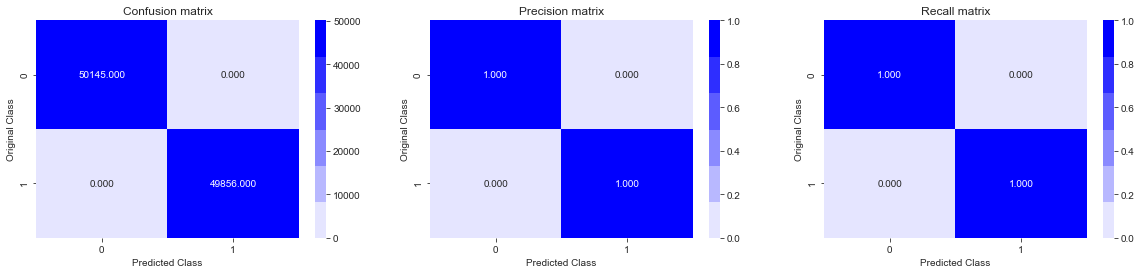

Test confusion_matrix


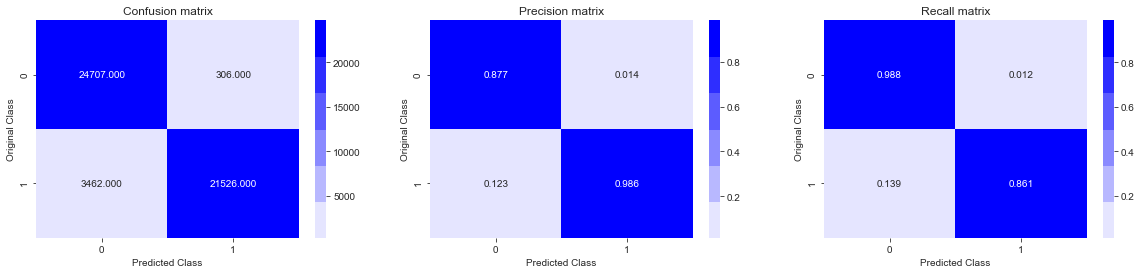

In [158]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

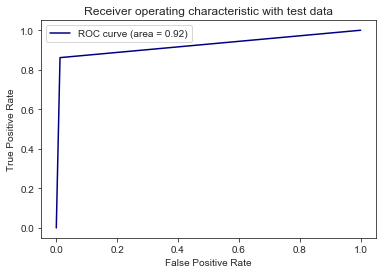

In [159]:
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

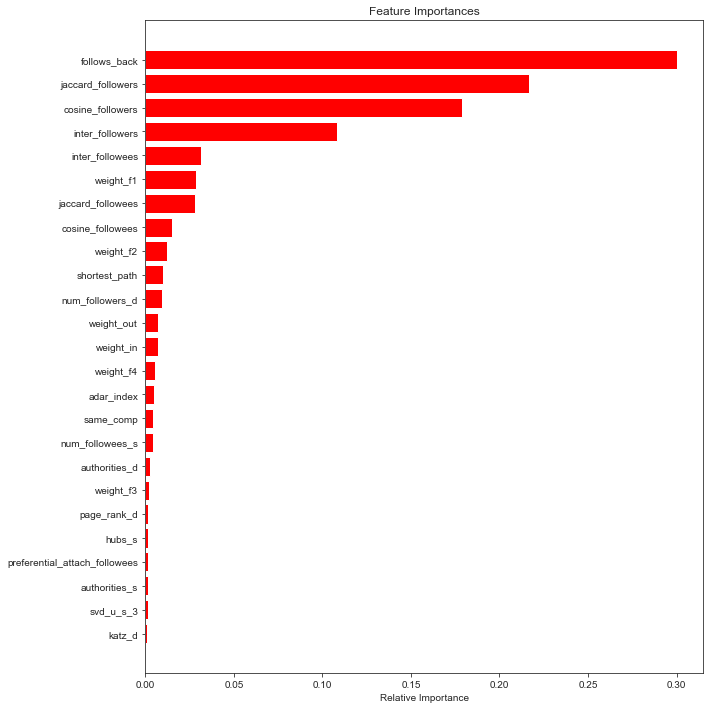

In [160]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Conclusion :
        

In [14]:
##http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model", "Hyper Parameter", " Train F1score" ,"Test F1score "]
x.add_row(["Random Forest Classifier",'''{'max_depth':14,'n_estimators':121}''',0.96,0.918])
x.add_row(["XGBoost",'''{'max_depth': 14,'n_estimators': 235}''', 1, 0.919])
print(x)

+--------------------------+---------------------------------------+----------------+---------------+
|          Model           |            Hyper Parameter            |  Train F1score | Test F1score  |
+--------------------------+---------------------------------------+----------------+---------------+
| Random Forest Classifier |  {'max_depth':14,'n_estimators':121}  |      0.96      |     0.918     |
|         XGBoost          | {'max_depth': 14,'n_estimators': 235} |       1        |     0.919     |
+--------------------------+---------------------------------------+----------------+---------------+


### Steps:
### 1. Exploratory Data Analysis
    * 1.1 Number of Followers for each person 
    * 1.2 Number of Followees for each person 
    * 1.3 Both followers + following 
### 2. Posing a problem as classification problem¶
    * 2.1 Generating some edges which are not present in graph for supervised learning
    * 2.2 Training and Test data split:
### FB featurization
    *  Reading Data
#### 2. Similarity measures
    * 2.1 Jaccard Distance:
    * 2.2 Cosine distance
### 3. Ranking Measures
    * 3.1 Page Ranking
### 4. Other Graph Features
    * 4.1 Shortest path
    * 4.2 Checking for same community
    * 4.3 Adamic/Adar Index
    * 4.4 If person was following back:
    * 4.5 Katz Centrality
    * 4.6 Hits Score
### 5. Featurization
    * 5. 1 Reading a sample of Data from both train and test
    * 5.2 Adding a set of features:jaccard distance,cosine features,num_followers,inter_followers
    * 5.3 Adding a set of features : adar index,is following back,belongs to same weakly connect       components,shortest path between source and destination
### 5.4 Adding new set of features: weight features
    * 5.5 Adding new set of features: SVD features
    * 5.6 Adding new Feature:  Preferential attachment 
    * 5.7 Adding new Feature:  SVD_dot 
### 6. FB_Models
###### 6.1 Applying Random Forest Classifier: 
		* hyperparameter tuning 
		* Confusion matrix , precisiona nd recall matrix
		* Roc with test data
		* feature importances
###### 6.1 Applying XGBoost:
		* hyperparameter tuning 
		* Confusion matrix , precisiona nd recall matrix
		* Roc with test data
		* feature importances